## METHOD

In order to increase the accuracy of the classifier, it is important for it to use as less as possible predictor variables. As the prediction of heart diagnosis requires many variables, only those will be chosen with stronger correlation to the target variable. The data analysis will be conducted using classification. The first step for a classification is to split the dataset into a train and test split. Next, split the training data for train or validation. In order to choose the most optimal K value, a recipe will be created with the specified predictors using the nearest_neighbour function. As an optimal K value is obtained from the validation, we can proceed to the next step of retraining the classifier. To understand the accuracy of the classifier, it will be tested on the test set. We will be using visualization methods that include histograms, boxplots and barplots to apprehend the correlation between the predictors and the target class. 


# Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(dplyr)
library(gridExtra)
library(RColorBrewer)
set.seed(2022)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_dataset <- read.csv(file = url, header = F)

#Prepare column names
names <- c("Age",
           "Sex",
           "Chest_Pain_Type",
           "Resting_Blood_Pressure",
           "Serum_Cholesterol",
           "Fasting_Blood_Sugar",
           "Resting_ECG",
           "Max_Heart_Rate_Achieved",
           "Exercise_Induced_Angina",
           "ST_Depression_Exercise",
           "Peak_Exercise_ST_Segment",
           "Num_Major_Vessels_Flouro",
           "Thalassemia",
           "Diagnosis_Heart_Disease") #Making columns human readable

#Apply column names to the dataframe
colnames(heart_disease_dataset) <- names

heart_disease_dataset |> head(5)

,Age,Sex,Chest_Pain_Type,Resting_Blood_Pressure,Serum_Cholesterol,Fasting_Blood_Sugar,Resting_ECG,Max_Heart_Rate_Achieved,Exercise_Induced_Angina,ST_Depression_Exercise,Peak_Exercise_ST_Segment,Num_Major_Vessels_Flouro,Thalassemia,Diagnosis_Heart_Disease
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Table 1. Sample of dataset with the predictors

In [82]:
heart_dataset_tidy <- heart_disease_dataset |> 
 mutate_at(c("Resting_ECG", 
                "Fasting_Blood_Sugar", 
                "Sex", 
                "Diagnosis_Heart_Disease", 
                "Exercise_Induced_Angina",
                "Peak_Exercise_ST_Segment", 
                "Chest_Pain_Type"), as_factor) |>
    mutate(Num_Major_Vessels_Flouro = as.numeric(Num_Major_Vessels_Flouro), Age = as.numeric(Age))  |> #Converting data types to factors and numerics since there are no decimals for doubles
    mutate(Diagnosis_Heart_Disease = fct_lump(Diagnosis_Heart_Disease, other_level = "1")) |> #Since a patient either has heart disease or doesn't this needs to be a binary value
    filter(across(everything(),
      .fns = ~ !is.na(.x), cols != "?")) # Removing NA's and ?

heart_dataset_tidy |> head(5)
# Note while there are multiple people with the same age in our dataset this does not mean we must get rid of these rows because they are no repeated

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message:
“Using `across()` in `filter()` is deprecated, use `if_any()` or `if_all()`.”


,Age,Sex,Chest_Pain_Type,Resting_Blood_Pressure,Serum_Cholesterol,Fasting_Blood_Sugar,Resting_ECG,Max_Heart_Rate_Achieved,Exercise_Induced_Angina,ST_Depression_Exercise,Peak_Exercise_ST_Segment,Num_Major_Vessels_Flouro,Thalassemia,Diagnosis_Heart_Disease
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<fct>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,1
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0


The above table consists of the first 5 rows from the dataset with the "NA" and "?" values dropped.

### Table 2. Proportions of the Heart diagnosis (0 - No heart disease present, 1 - heart disease present)

In [4]:
heart_dataset_proportions <- heart_dataset_tidy |>
                                group_by(Diagnosis_Heart_Disease) |>
                                summarize(n = n()) |>
                                mutate(percent = 100*n/nrow(heart_dataset_tidy))

heart_dataset_proportions

Diagnosis_Heart_Disease,n,percent
<fct>,<int>,<dbl>
0,161,53.84615
1,138,46.15385


Table 2 above shows that the heart_dataset_tidy dataset has 53.84% of people diagnosed do not have the heart disease present (Diagnosis_Heart_Disease == 0) whereas 46.15% of the dataset have the heart disease present (Diagnosis_Heart_Disease == 1).

### Table 3. The mean values of the variables in regard to the target class

In [5]:
# some of the factor variables are converted to numeric to summarize the mean

heart_dataset_tidy2 <- heart_dataset_tidy |>    
                    mutate(Sex = as.numeric(Sex),
                          Chest_Pain_Type = as.numeric(Chest_Pain_Type),
                          Fasting_Blood_Sugar = as.numeric(Fasting_Blood_Sugar),
                          Resting_ECG = as.numeric(Resting_ECG),
                          Exercise_Induced_Angina = as.numeric(Exercise_Induced_Angina),
                          Peak_Exercise_ST_Segment = as.numeric(Peak_Exercise_ST_Segment),
                          Thalassemia = as.numeric(Thalassemia)) |>
                    drop_na()

mode_stats <- heart_dataset_tidy2 |>
                group_by(Diagnosis_Heart_Disease) |>
                summarize(mean_age = mean(Age),
                          mean_sex = mean(Sex),
                          mean_cp_type = mean(Chest_Pain_Type),
                          mean_resting_bp = mean(Resting_Blood_Pressure),
                          mean_serum_c = mean(Serum_Cholesterol),
                          mean_fasting_b_s = mean(Fasting_Blood_Sugar),
                          mean_resting_ECG = mean(Resting_ECG),
                          mean_max_hrate = mean(Max_Heart_Rate_Achieved),
                          mean_exang = mean(Exercise_Induced_Angina),
                          mean_ST_dep = mean(ST_Depression_Exercise),
                          mean_Peak_e = mean(Peak_Exercise_ST_Segment),
                          mean_NMVF = mean(Num_Major_Vessels_Flouro),
                          mean_thal = mean(Thalassemia))

mode_stats
                          
                          

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Diagnosis_Heart_Disease,mean_age,mean_sex,mean_cp_type,mean_resting_bp,mean_serum_c,mean_fasting_b_s,mean_resting_ECG,mean_max_hrate,mean_exang,mean_ST_dep,mean_Peak_e,mean_NMVF,mean_thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.64375,1.556250,2.793750,129.175,243.4938,1.143750,1.843750,158.5813,1.143750,0.598750,1.412500,0.275000,3.787500
1,56.75912,1.817518,3.583942,134.635,251.8540,1.145985,2.175182,139.1095,1.540146,1.589051,1.824818,1.145985,5.832117


From table 3 we see the mean values of the variables in relation to Diagnosis_Heart_Disease. We can observe a clear difference between the mean values of variables that relate to heart disease being present (Diagnosis_Heart_Disease == 1) and absent (Diagnosis_Heart_Disease == 0). Some variables like the mean_ST_dep for heart disease absent is 0.598 whereas for heart disease present it is 1.589. There some variables that show very small difference such as mean_serum_c for disease absent is 243.493 and present is 251.854. This means that the variable mean_serum_c does not have a strong relation with the target class. The table illustrates that due to the differences in mean values for the target class category, the classifier can be trained to predict the heart diagnosis. Further visualisation will help in choosing the relevant variables for training the classifier. 

# Visualisations 

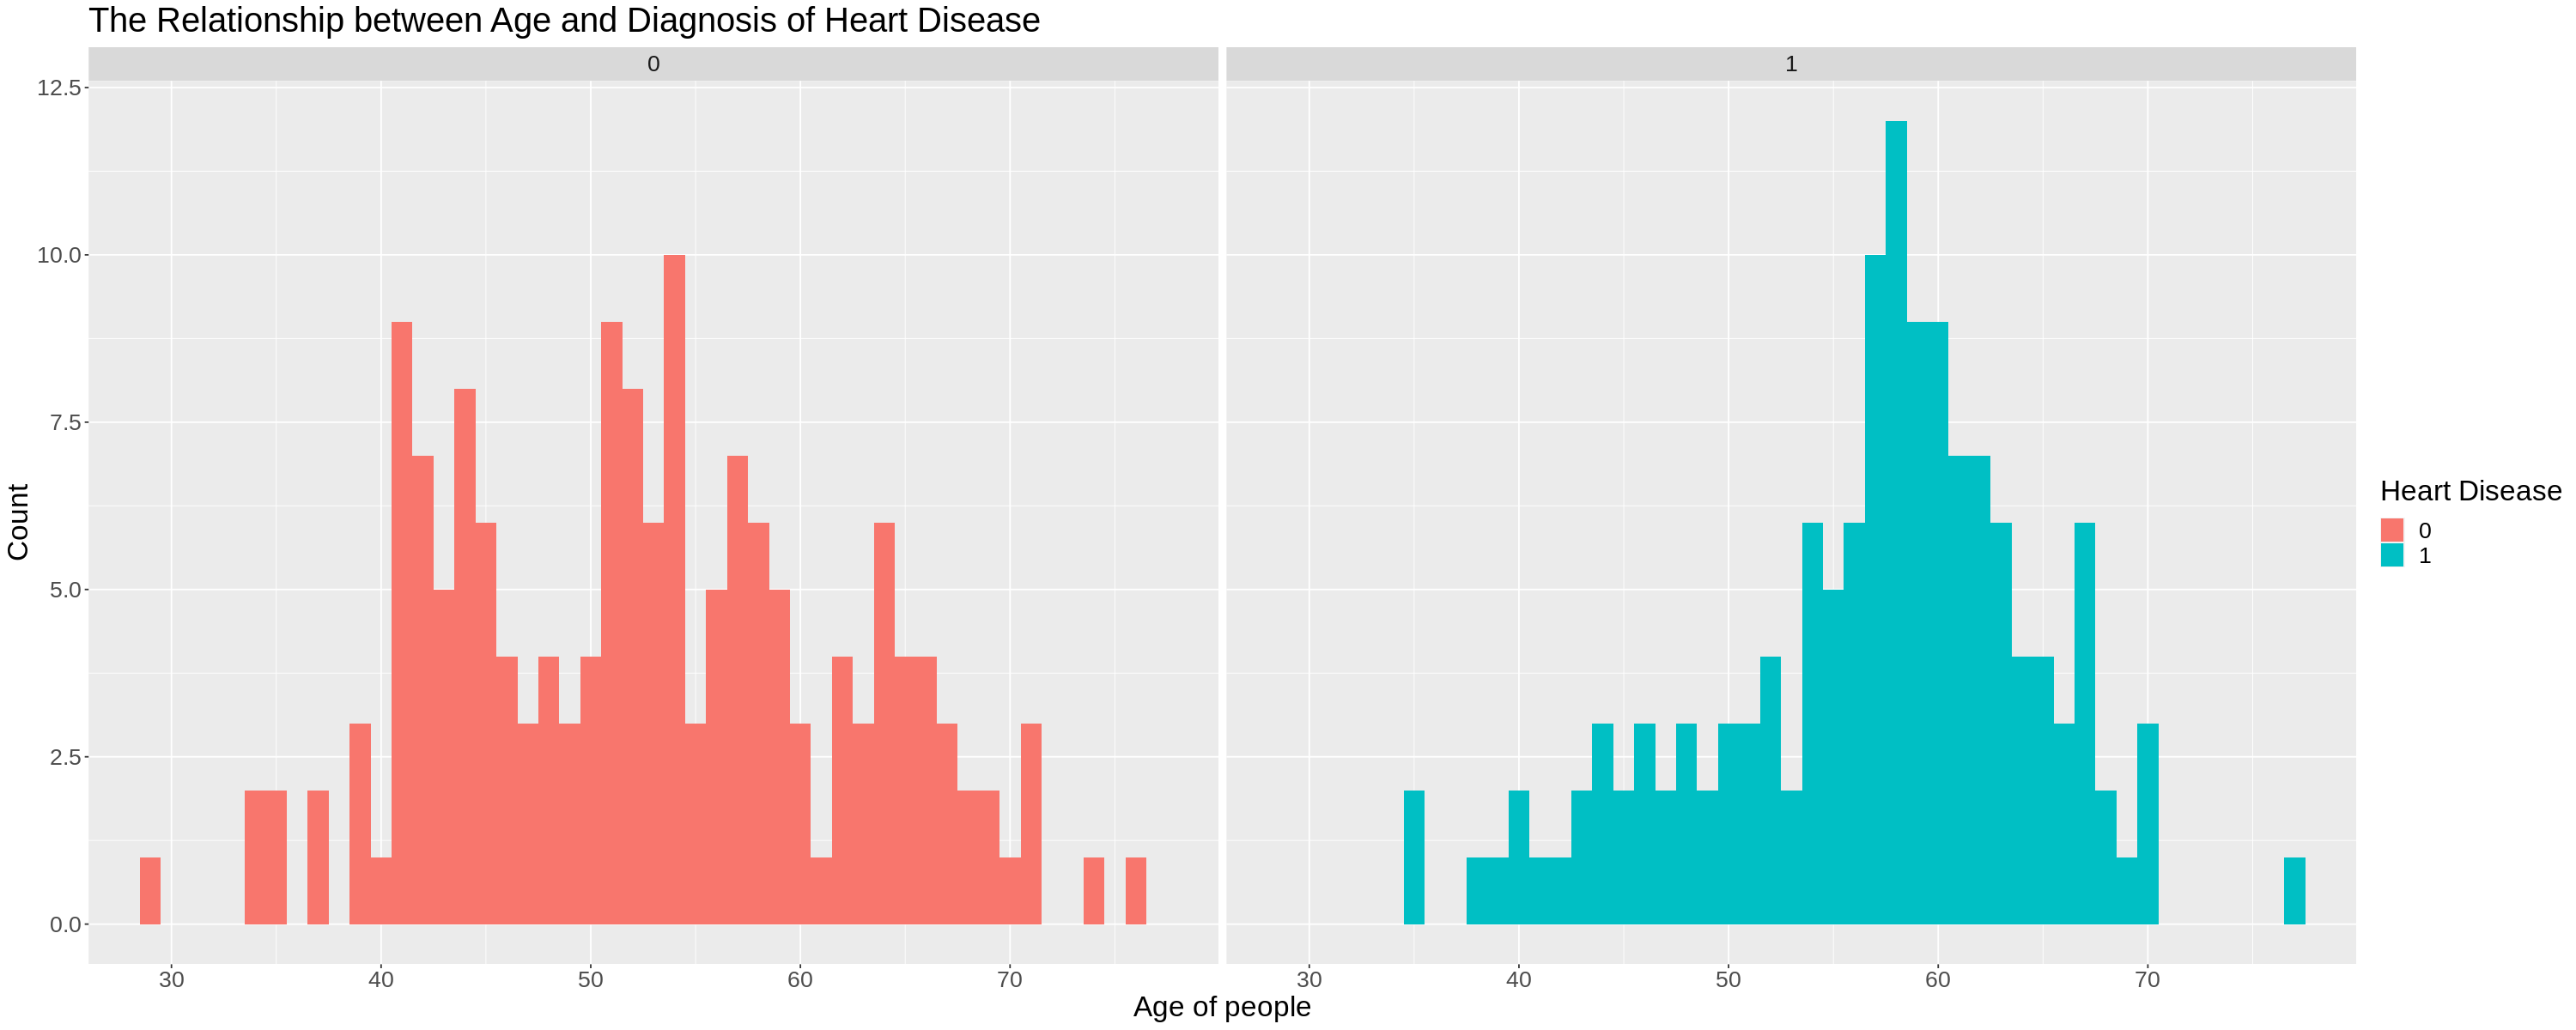

In [36]:
options(repr.plot.width = 25, repr.plot.height = 10)

age_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Age, fill = Diagnosis_Heart_Disease))+
    geom_histogram(binwidth = 1)+
    facet_grid(cols = vars(Diagnosis_Heart_Disease))+
    ggtitle("The Relationship between Age and Diagnosis of Heart Disease")+
    labs(x = "Age of people", y = "Count", fill = "Heart Disease")+
    theme(text = element_text(size = 20))
age_plot

Above are two histograms faceted based on the absence (Heart disease Diagnosis = 0) and presence (Heart Disease Diagnosis = 1) that illustrate different distribution shapes. This suggests that age(1) does have a relationship with heart disease. The plot with the absence of heart disease is normally distributed whereas the plot with the presence of heart disease is skewed towards the left. This suggests that older people have heart disease. 

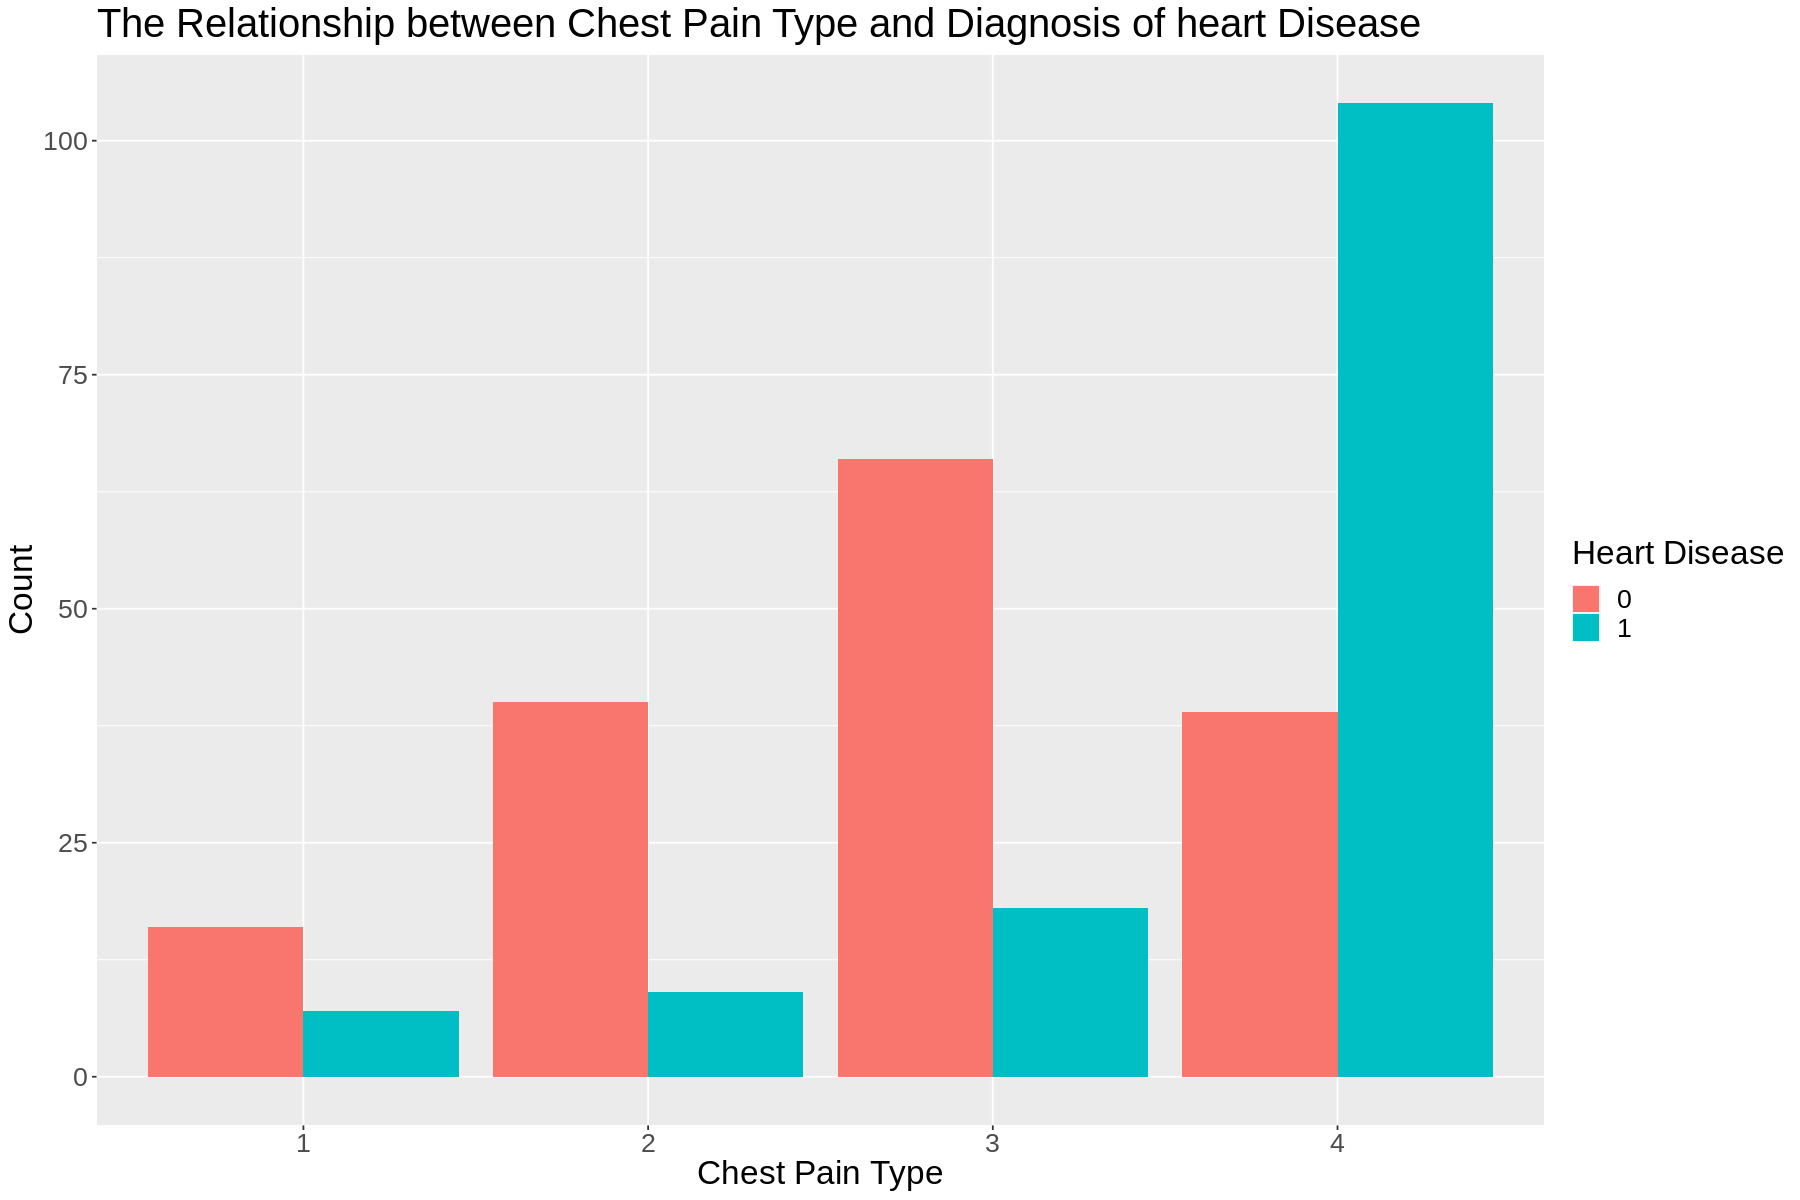

In [72]:
options(repr.plot.width = 15, repr.plot.height = 10)
cp_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Chest_Pain_Type, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "dodge")+
    labs(x = "Chest Pain Type", y = "Count", fill = "Heart Disease")+
    ggtitle("The Relationship between Chest Pain Type and Diagnosis of heart Disease")+
    theme(text = element_text(size = 20))
cp_plot

The plot showing the relationship between Chest Pain Type and Diagnosis of heart Disease illustrates that asymptomatic angina (Chest_Pain_Type = 4) has the highest count for the heart disease presence. Contrarily, typical angina has the lowest count. This suggests that Chest_Pain_Type(2) is a relevant predictor for predicting heart disease. 

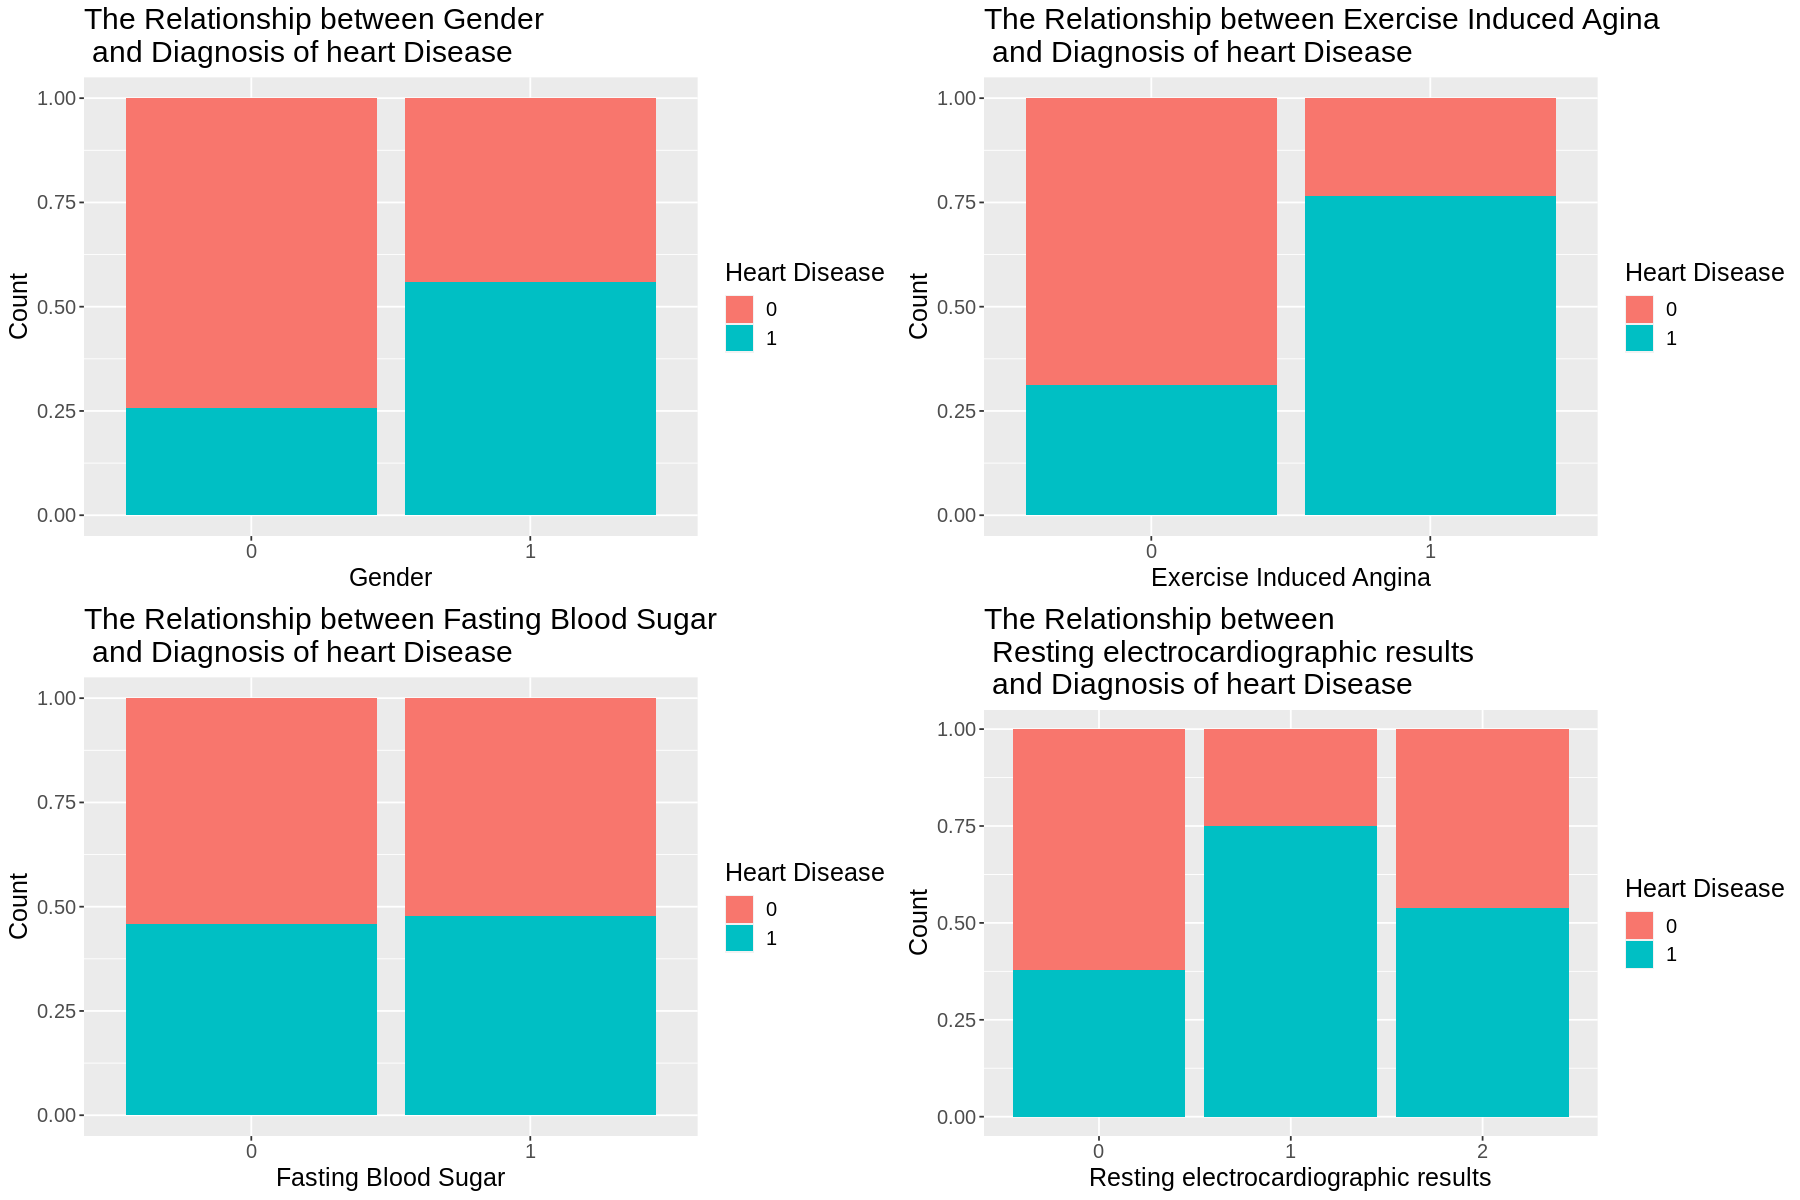

In [73]:
options(repr.plot.width = 15, repr.plot.height = 10)

sex_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Sex, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "fill")+
    labs(x = "Gender", y = "Count", fill = "Heart Disease") +
    ggtitle("The Relationship between Gender \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

ecg_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Resting_ECG, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "fill")+
    labs(x = "Resting electrocardiographic results", y = "Count",  fill = "Heart Disease")+
    ggtitle("The Relationship between \n Resting electrocardiographic results \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

fbs_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Fasting_Blood_Sugar, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "fill")+
    labs(x = "Fasting Blood Sugar", y = "Count", fill = "Heart Disease")+
    ggtitle("The Relationship between Fasting Blood Sugar \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

exercise_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Exercise_Induced_Angina, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "fill")+
    labs(x = "Exercise Induced Angina", y = "Count",  fill = "Heart Disease")+
    ggtitle("The Relationship between Exercise Induced Agina \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

grid.arrange(sex_plot, exercise_plot, fbs_plot, ecg_plot, nrow = 2)

The plots arranged in a grid above are of the relationship between 4 different variables and the target class. The top two plots illustrate differences in proportions for absence and presence of heart disease clearly. The variables represented against the target are Sex(3) and Exercised Induced Angina(4). The plot for fasting blood sugar shows no correlation with the diagnosis of heart. the resting electrocardiographic results(5) show different correlations for every class, where class 2 illustrates highest proportions of patients having a heart disease.  

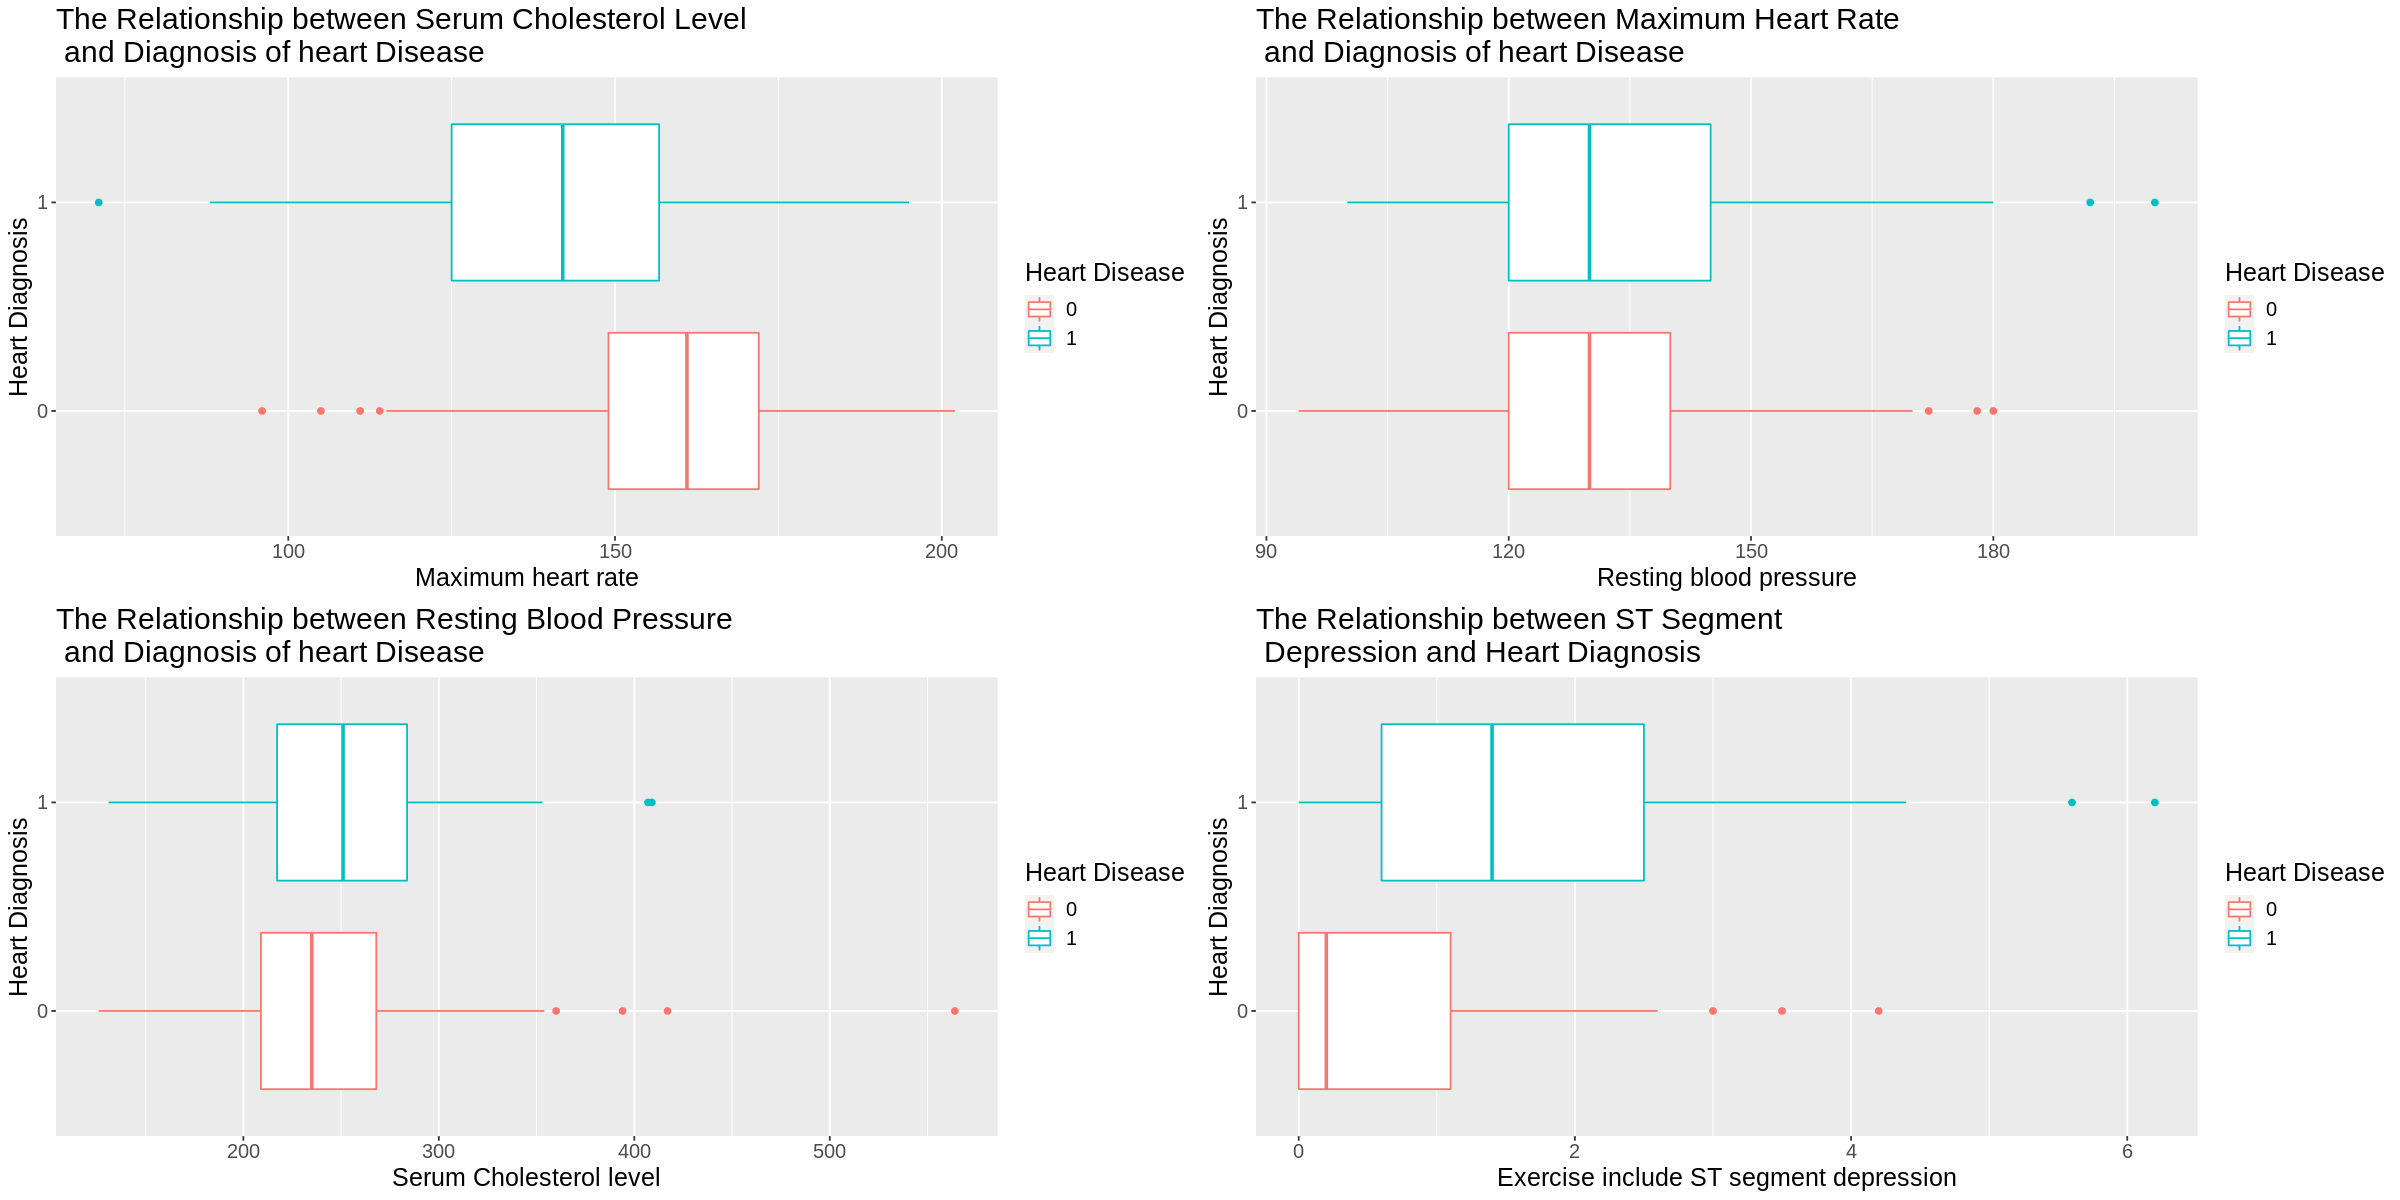

In [39]:
options(repr.plot.width = 20, repr.plot.height = 10)
bp_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Resting_Blood_Pressure, y = Diagnosis_Heart_Disease, color = Diagnosis_Heart_Disease)) +
    geom_boxplot() +
    labs(x = "Resting blood pressure", y = "Heart Diagnosis", color = "Heart Disease") +
    ggtitle("The Relationship between Maximum Heart Rate \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

sc_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Serum_Cholesterol, y = Diagnosis_Heart_Disease, color = Diagnosis_Heart_Disease)) +
    geom_boxplot() +
    labs(x = "Serum Cholesterol level", y = "Heart Diagnosis", color = "Heart Disease") +
    ggtitle("The Relationship between Resting Blood Pressure \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

hr_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Max_Heart_Rate_Achieved, y = Diagnosis_Heart_Disease, color = Diagnosis_Heart_Disease)) +
    geom_boxplot() +
    labs(x = "Maximum heart rate", y = "Heart Diagnosis", color = "Heart Disease") +
    ggtitle("The Relationship between Serum Cholesterol Level \n and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))

de_plot <- heart_dataset_tidy|>
    ggplot(aes(x = ST_Depression_Exercise, y = Diagnosis_Heart_Disease, color = Diagnosis_Heart_Disease)) +
    geom_boxplot() +
    labs(x = "Exercise include ST segment depression", y = "Heart Diagnosis", color = "Heart Disease") +
    ggtitle("The Relationship between ST Segment \n Depression and Heart Diagnosis")+
    theme(text = element_text(size = 15))


grid.arrange(hr_plot, bp_plot, sc_plot, de_plot, nrow = 2)

Above plots are boxplots for comparing the distribution of data for each target class (absence(= 0) or presence(= 1) of heart disease). Only two of the above plots show distinct differences in how the data are distributed. This occurs for the variable Maximum heart rate (6) and exercise include ST segment depression (7). The plot on the bottom left corner depicting a correlation of serum cholestrol level with heart diagnosis also shows a distinct difference in how the data is centered. In datasets of heart diseases, minute differences in the differences matter which is why serum cholestrol level (8) has to be chosen as a predictor. The upper left plot has the center of data points to be almost the same in the case of heart disease present and absent. 

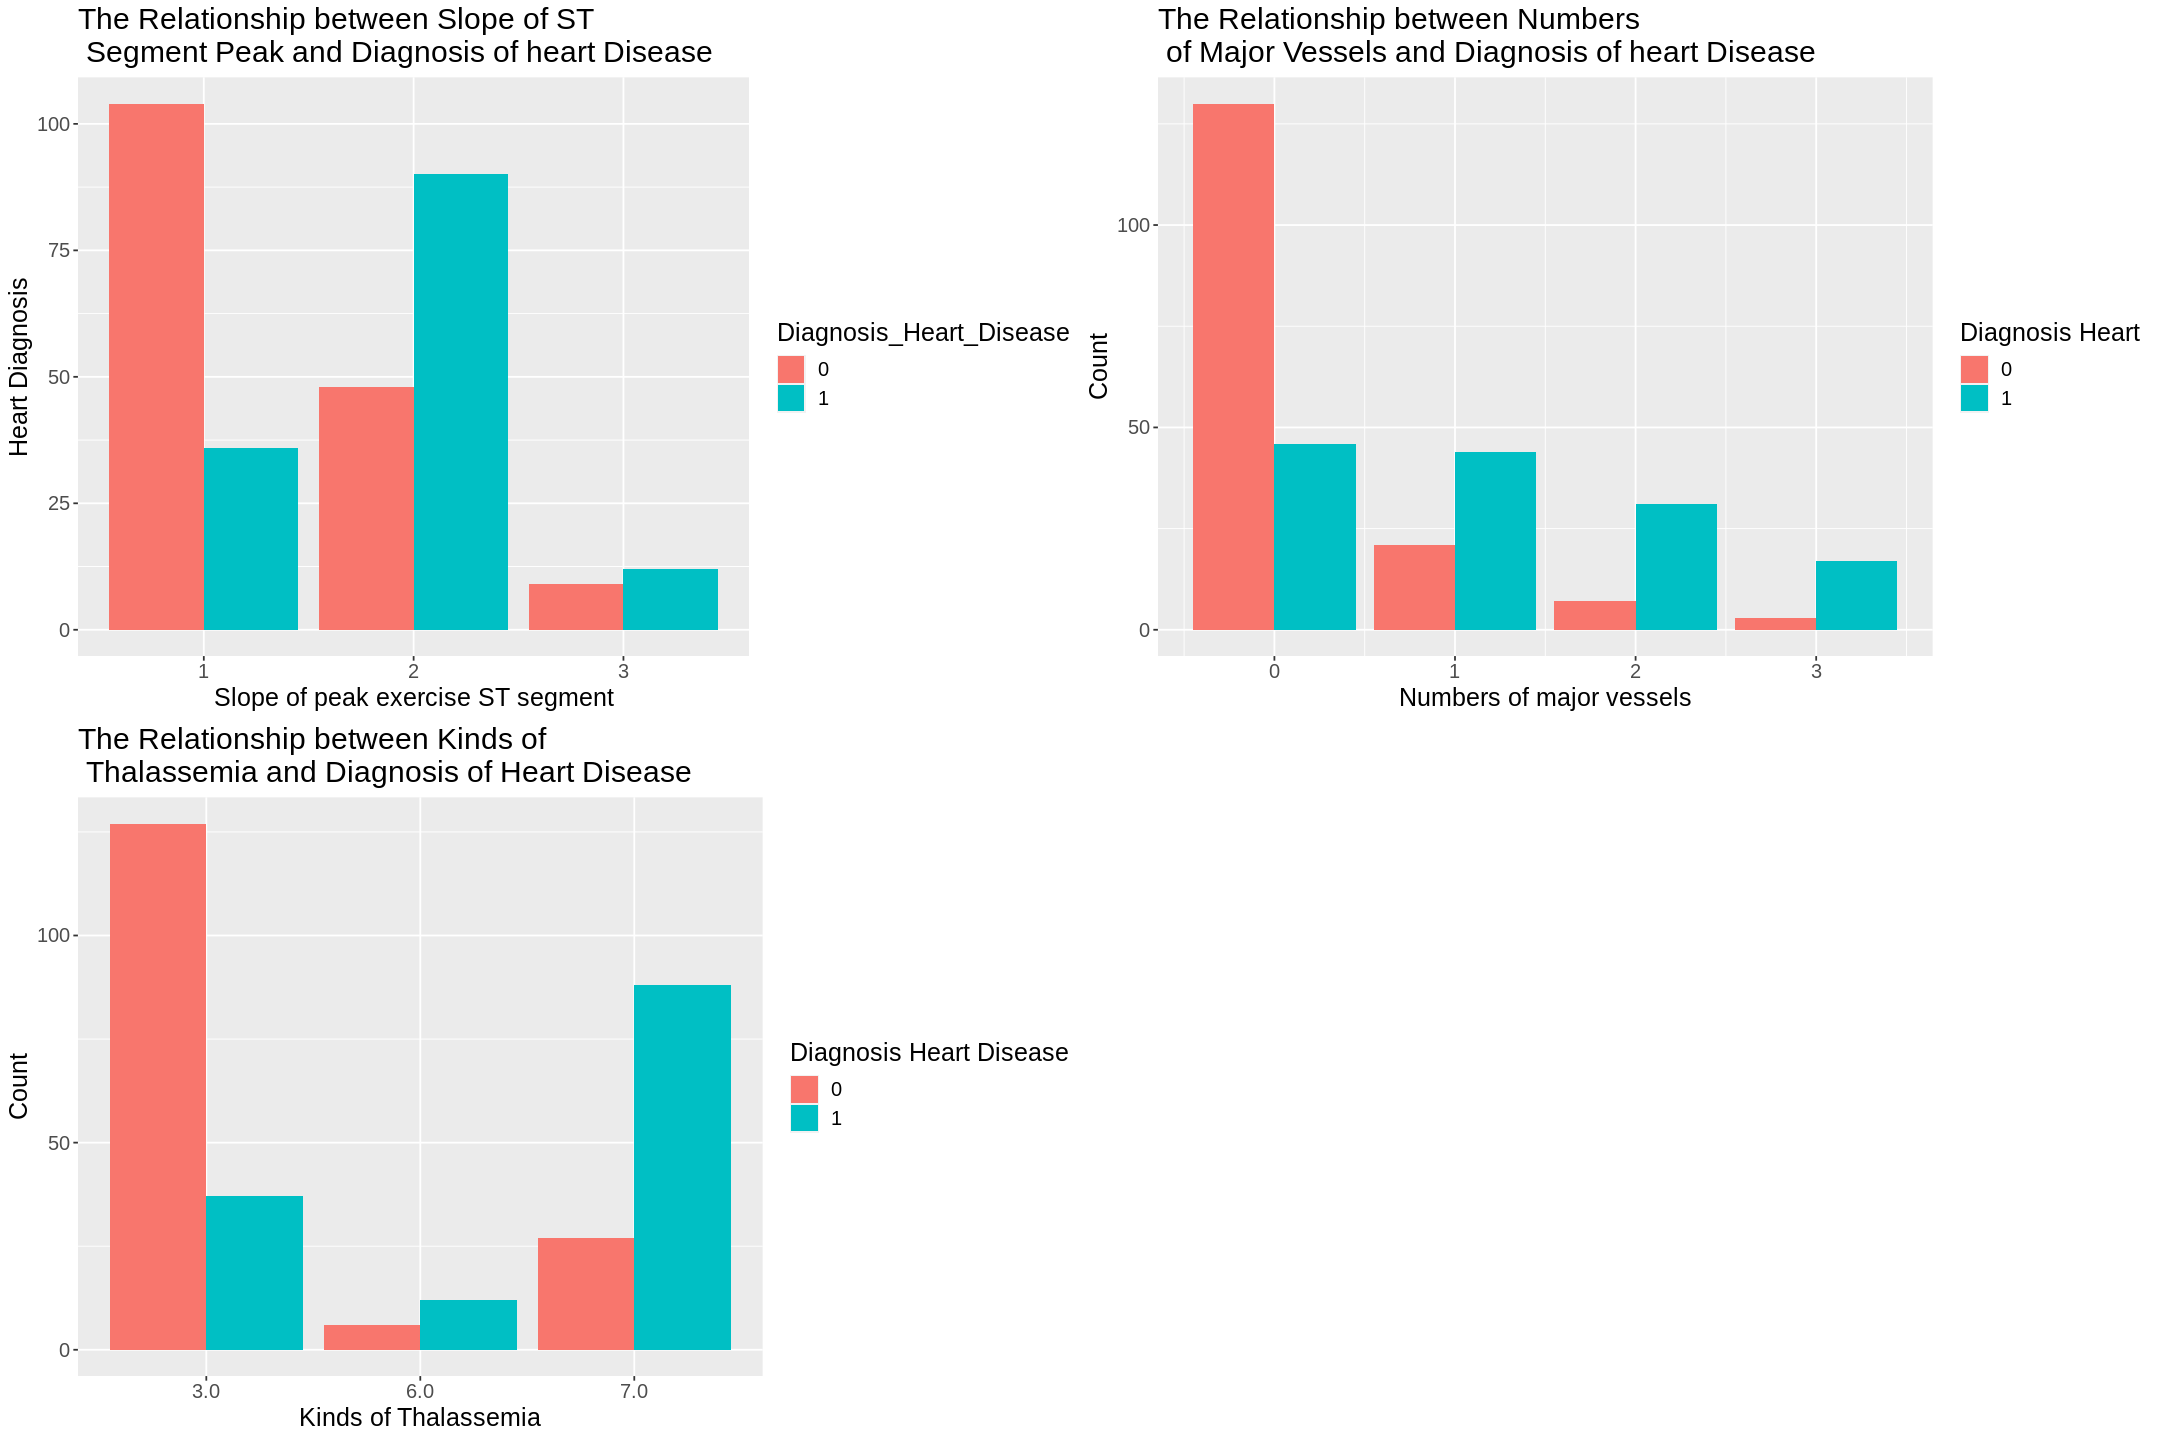

In [76]:
options(repr.plot.width = 18, repr.plot.height = 12)

peak_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Peak_Exercise_ST_Segment, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "dodge")+
    labs(x = "Slope of peak exercise ST segment", y = "Heart Diagnosis", color = "Heart Diagnosis") +
    ggtitle("The Relationship between Slope of ST \n Segment Peak and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))



vessel_plot <- heart_dataset_tidy |>
    ggplot(aes(x = Num_Major_Vessels_Flouro, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "dodge")+
    labs(x = "Numbers of major vessels", y = "Count", fill = "Diagnosis Heart ")+
    ggtitle("The Relationship between Numbers \n of Major Vessels and Diagnosis of heart Disease")+
    theme(text = element_text(size = 15))


tha_plot <- heart_dataset_tidy |>
    filter(Thalassemia != "?")|> # some of values exist in terms of '?' which have to be removed 
    ggplot(aes(x = Thalassemia, fill = Diagnosis_Heart_Disease)) +
    geom_bar(position = "dodge")+
    labs(x = "Kinds of Thalassemia", y = "Count", fill = "Diagnosis Heart Disease")+
    ggtitle("The Relationship between Kinds of \n Thalassemia and Diagnosis of Heart Disease")+
    theme(text = element_text(size = 15))



grid.arrange(peak_plot, vessel_plot, tha_plot, nrow = 2)

All of the plots above are formed with regard to the target variable. The three of them illustrate a clear distinction in their correlation. Slope of peak exercise ST segment (9) illustrates that the highest count with heart disease present is at 2. For number of major vessels (10) heart disease is mostly present for greater than 0 but majority of normal patients have 0 major vessels. Lastly, class 7 of the kind of thalassemia (11) has the greatest count for heart disease being present. 

### DATA ANALYSIS 

From the above visualisations, we were able to select a total of 11 variables portraying a stronger correlation with the target variable. The main reason of not choosing all the variables is to prevent redundancy or irrelevance. Adding variables with weaker correlations lead to overfitting of the model because those variables would introduce more noise. 

The variables denoted from 1-11 are chosen:

1. `Age`
2. `Chest_Pain_Type`
3. `Sex`
4. `Exercise_Induced_Angina`
5. `Resting_ECG`
6. `Max_Heart_Rate_Achieved`
7. `ST_Depression_Exercise`
8. `Serum_Cholesterol`
9. `Peak_Exercise_ST_Segment`
10. `Num_Major_Vessels_Flouro`
11. `Thalassemia`

In [77]:
heart_model_dataset <- heart_disease_dataset |> 
                                            select(Age, Sex, Chest_Pain_Type, 
                                                    Exercise_Induced_Angina, Max_Heart_Rate_Achieved, 
                                                    ST_Depression_Exercise, Peak_Exercise_ST_Segment, 
                                                    Num_Major_Vessels_Flouro, Thalassemia, Serum_Cholesterol, 
                                                    Resting_ECG, Diagnosis_Heart_Disease) |>
                                            mutate(Diagnosis_Heart_Disease = as_factor(Diagnosis_Heart_Disease)) |>
                                            mutate(Num_Major_Vessels_Flouro = as.numeric(Num_Major_Vessels_Flouro)) |> # All variables except target variabe have to be converted to numeric
                                            mutate(Thalassemia = as.numeric(Thalassemia))|>
                                            mutate(Diagnosis_Heart_Disease = fct_lump(Diagnosis_Heart_Disease, other_level = "1"))|>
                                            drop_na()
                                  

heart_model_dataset

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Age,Sex,Chest_Pain_Type,Exercise_Induced_Angina,Max_Heart_Rate_Achieved,ST_Depression_Exercise,Peak_Exercise_ST_Segment,Num_Major_Vessels_Flouro,Thalassemia,Serum_Cholesterol,Resting_ECG,Diagnosis_Heart_Disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,0,150,2.3,3,0,6,233,2,0
67,1,4,1,108,1.5,2,3,3,286,2,1
67,1,4,1,129,2.6,2,2,7,229,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,0,141,3.4,2,2,7,193,0,1
57,1,4,1,115,1.2,2,1,7,131,0,1
57,0,2,0,174,0.0,2,1,3,236,2,1


The original heart dataset consisted of 4 classes of heart diagnosis where 0 was absence and greater than 0 was the stage of critical. The class is mutated to be either 0 or 1 because heart disease can be present or absent, according to the aim of the model which is only to predict the presence or absence. 

### Splitting the dataset into 75% training and 25% testing 

In [78]:
set.seed(2022)
heart_split <- initial_split(heart_model_dataset, prop = 0.75, strata = Diagnosis_Heart_Disease)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

### KNN classification 

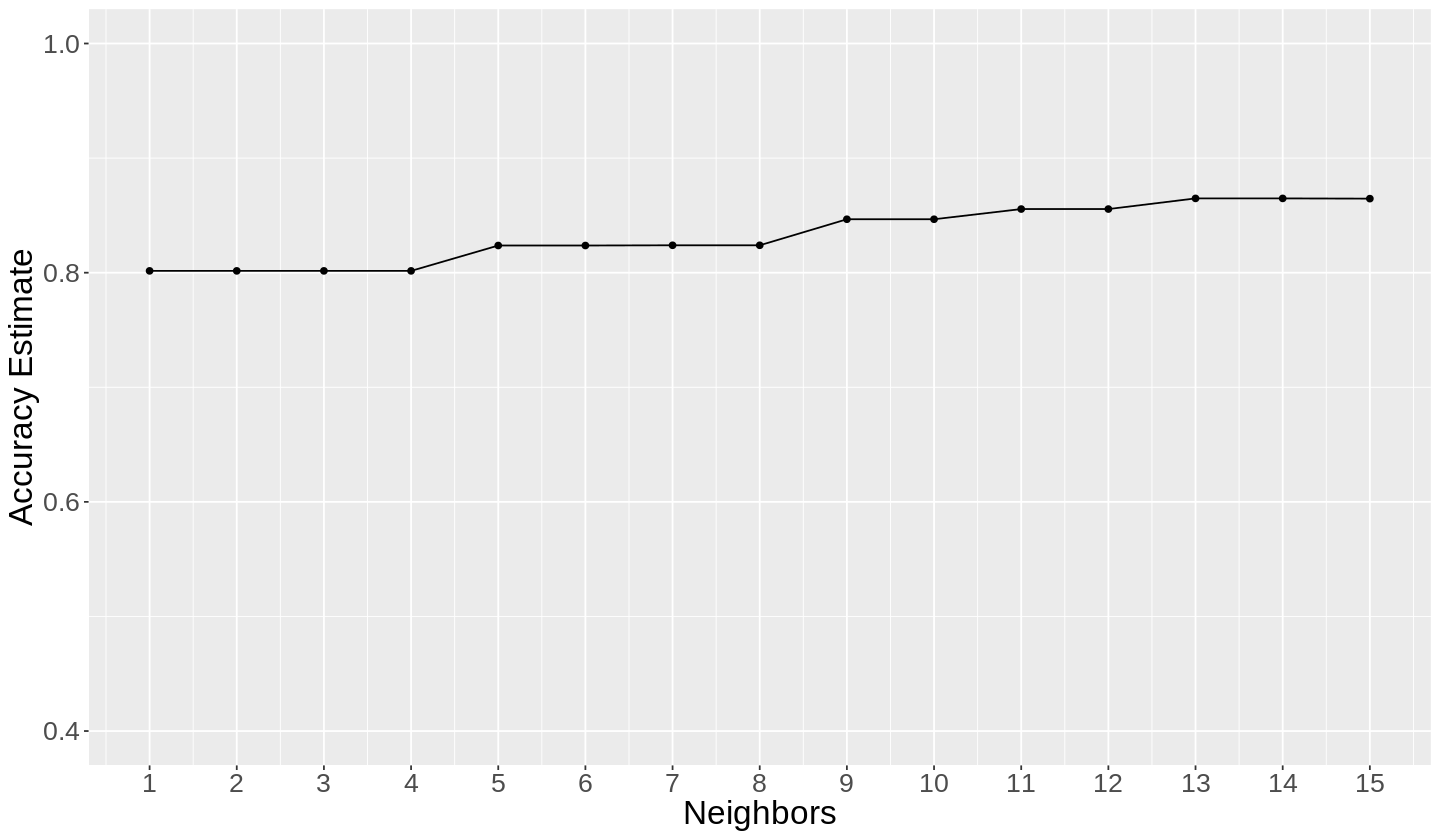

In [79]:
set.seed(2022)
options(repr.plot.width = 12, repr.plot.height = 7)


heart_vfold <- vfold_cv(heart_training, v = 10, strata = Diagnosis_Heart_Disease)


heart_recipe <- recipe(Diagnosis_Heart_Disease ~ ., data = heart_training)|>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn")|>
                set_mode("classification")

k_vals <- tibble(neighbors=seq(from=1, to=15, by=1))

heart_results <- workflow()|>
                add_recipe(heart_recipe)|>
                add_model(knn_spec)|>
                tune_grid(resamples = heart_vfold, grid = k_vals)|>
                collect_metrics()|>
                filter(.metric == "accuracy") 



heart_plot <- heart_results |>
                ggplot(aes(x = neighbors, y = mean))+
                geom_point()+
                geom_line()+
                labs(x = "Neighbors", y = "Accuracy Estimate")+
                scale_x_continuous(breaks = seq(0, 15, by = 1)) +
                scale_y_continuous(limits = c(0.4, 1.0))+
                theme(text = element_text(size = 20))

heart_plot

The above code is of training the KNN classifier. The code uses a 10 fold cross validation with neighbours from 1 to 15. The aim of the classifier is to predict the presence of heart disease in patients according to 11 different predictors. The heart_plot above shows the relationship between Neighbours (x axis) and accuracy estimate (y axis). From the plot we can see the highest accuracy estimate is achieved at k = 14. This k value can be chosen as it shows the highest accuracy estimate and the k values before and after it also stay at the same level. 

In [80]:
k_chosen <- 14


heart_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_chosen)|> # neighbors = best k value
    set_engine("kknn")|>
    set_mode("classification")

heart_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(heart_best_spec)|>
    fit(data = heart_training)

heart_predictions <- predict(heart_fit, heart_testing)|>
    bind_cols(heart_testing)
                                    
heart_acc <- heart_predictions |>
    metrics(truth = Diagnosis_Heart_Disease, estimate = .pred_class)|>
    select(.metric, .estimate)
    head(1)
                                    

heart_acc

[1] 1

.metric,.estimate
<chr>,<dbl>
accuracy,0.7866667
kap,0.5729537


Now, after the k value is chosen, it is used to train the final version of our KNN classification algorithm to predict the presence of heart disease using 11 different variables. In the code above, after training, the prediction column is binded to the training dataset. 

Finally, the table above represents the accuracy of the final version of KNN classifier on the testing dataset (heart_testing). The accuracy achieved is 78.67% on the testing dataset with the use of 14 neighbours. For the following dataset it can be deduced that 77.67% is a good estimate. The reason behind this is that predicting heart disease itself is a very difficult task, as many variables are held account when predicting it, there may be cases where these variables are misdiagnosed with regards to the disease. 

In [81]:
heart_cm <- heart_predictions |>
    conf_mat(truth = Diagnosis_Heart_Disease, estimate = .pred_class)

heart_cm

          Truth
Prediction  0  1
         0 31  7
         1  9 28

The confusion matrix table above illustrates the predictions made on the testing dataset. This tells that only 9 patients of the patients were classified incorrectly for the absence of heart disease and 7 patients classified with the presence of heart disease. 